In [1]:
%pylab inline 

import gym
from gym import error, spaces, utils
from gym.utils import seeding
from collections import Counter
import time
import progressbar as pb

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent 
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

Populating the interactive namespace from numpy and matplotlib


Using Theano backend.
Using cuDNN version 7103 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:01:00.0)


In [2]:
# load the market data
input_source = np.load(open('../deep_learning_trader/NEAT/data_spy.npy','rb'))
to_predict = np.load(open('../deep_learning_trader/NEAT/data_spy_targets.npy','rb'))

In [3]:
#plot(input_source[:,1]);

In [4]:
input_source = input_source.T
input_source.shape

(123883, 105)

In [5]:
bars_per_episode = 1000

class TradingEnv(gym.Env):
    
    """ This gym implements a simple trading environment for reinforcement learning. """
    
    metadata = {'render.modes': ['human']}
    
    def __init__(self):
        self.action_space = spaces.Discrete( 3 )
        self.observation_space= spaces.Box( np.min(input_source, axis=0), 
                                            np.max(input_source, axis=0) )
        self.reset()
        
    def _configure(self, display=None):
        self.display = display

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        
        assert self.action_space.contains(action), "%r (%s) invalid" % (action, type(action))
        
        if self.idx < self.end_idx:
            self.idx += 1
            done = False
        else:
            done = True
        
        info = {}
        
        observation = input_source[self.idx, :]
        
        reward = 0
        
        # execute the action and get the reward
        if action == 0: # buy 
            reward = (to_predict[self.idx] - to_predict[self.idx-1])*10000
        if action == 1: # sell
            reward = (to_predict[self.idx-1] - to_predict[self.idx])*10000
        
        return observation, reward, done, info
  
    def reset(self):
        # reset and return first observation
        self.idx = np.random.randint(0, input_source.shape[0] - bars_per_episode )
        self.end_idx = self.idx + bars_per_episode
        return input_source[self.idx, :]
    
    def _render(self, mode='human', close=False):
        #... TODO
        pass        

In [6]:
env = TradingEnv()

In [7]:
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(8))
model.add(Activation('relu'))
model.add(Dense(env.action_space.n, activation='linear'))

memory = SequentialMemory(limit=10000, window_length=1)
policy = BoltzmannQPolicy()
dqn = DQNAgent(model=model, 
               nb_actions=env.action_space.n, 
               memory=memory, 
               nb_steps_warmup=10,
               enable_double_dqn=True, 
               enable_dueling_network=True, 
               dueling_type='avg', 
               target_model_update=1e-2, 
               policy=policy)
dqn.compile(Adam(lr=0.002), metrics=['mae'])

In [8]:
# training is here
h = dqn.fit(env, nb_steps=150000, nb_max_episode_steps=bars_per_episode, visualize=False, verbose=1)
rewards = h.history['episode_reward']

Training for 150000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 46s 5ms/step - reward: 0.0386
10 episodes - episode_reward: 38.570 [-63.500, 158.500] - loss: 6.897 - mean_absolute_error: 4.852 - mean_q: 6.539

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 39s 4ms/step - reward: -0.0066
10 episodes - episode_reward: -6.650 [-251.200, 170.800] - loss: 7.368 - mean_absolute_error: 4.902 - mean_q: 6.685

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 39s 4ms/step - reward: -0.0354
10 episodes - episode_reward: -35.410 [-295.600, 112.300] - loss: 6.090 - mean_absolute_error: 2.940 - mean_q: 3.853

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 40s 4ms/step - reward: -7.4000e-04
10 episodes - episode_reward: -0.740 [-131.900, 108.400] - loss: 3.619 - mean_absolute_error: 2.057 - mean_q: 2.579

Interval 5 (40000 steps performed)
10000/10000 [===

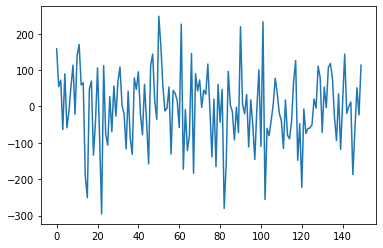

In [9]:
plot(rewards);

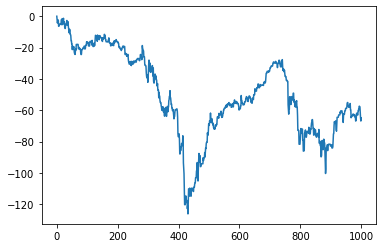

In [10]:
# visualize the behavior for one random episode
observation = env.reset()
done = False
navs = []
while not done:
    action = dqn.forward(observation)
    observation, reward, done, info = env.step(action)
    navs.append(reward)

kl = []
t = 0
for n in navs:
    t += n
    kl.append(t)
plot(kl);

In [11]:
# calculate the likelihood of success for any given episode
l = 100
krl = []
p = pb.ProgressBar(max_value=l)
for i in range(l):
    p.update(i)
    observation = env.reset()
    done = False
    navs = []
    while not done:
        action = dqn.forward(observation)
        observation, reward, done, info = env.step(action)
        navs.append(reward)
    krl.append(sum(navs))
p.finish()

krl = array(krl)
print('Profit likelihood: %3.3f%%' % (100*(sum(krl > 0) / len(krl))))

100% (100 of 100) |######################| Elapsed Time: 0:00:37 Time:  0:00:37


Profit likelihood: 46.000%
